# Voice Sex Classifer (Structured Data)

This notebook explores how well we can classify a speaker's sex using structured, fixed-length data extracted from voice recordings. While the raw voice recording is an unstructured data format, we can derive key features such as the mean values for pitch, formants, and MFCCs across the recording.

To classify speakers, we will experiment with several machine learning models, including Support Vector Machines (SVM), Random Forest, Logistic Regression, and Gradient Boosting classifiers.

## Data Loading and Cleaning

For this model we'll load a [Common Voice dataset by Mozilla](https://commonvoice.mozilla.org/en/datasets). The dataset I chose contains over 27,000 labelled voice recordings from people of different ages, genders, and backgrounds.

Load the TSV file into a pandas dataframe.

In [3]:
import pandas as pd
from pprint import pprint

df = pd.read_csv('../../datasets/cv-corpus-20.0-delta-2024-12-06/en/other.tsv', sep="\t")

print(df.shape)
pprint(list(df.columns))

(27087, 13)
['client_id',
 'path',
 'sentence_id',
 'sentence',
 'sentence_domain',
 'up_votes',
 'down_votes',
 'age',
 'gender',
 'accents',
 'variant',
 'locale',
 'segment']


For this model we're only concerned with the gender (our target variable), and the path to the audio file which we'll use to extract features.

In [4]:
df = df[['path', 'gender']]
df.head()

,path,gender
0,common_voice_en_41236242.mp3,NaN
1,common_voice_en_41247165.mp3,female_feminine
2,common_voice_en_41247167.mp3,female_feminine
3,common_voice_en_41247169.mp3,female_feminine
4,common_voice_en_41247171.mp3,female_feminine


Remove samples with missing gender or path values.

In [5]:
df.dropna(subset=['gender', 'path'], inplace=True)
df.shape

(11770, 2)

This has reduced the size of our dataset to just under 12,000 samples.

Our goal is to classify voice recordings as either male or female (not considering intersex for this study). Let's ensure we have an **even distribution** of both classes in our dataset.

In [6]:
print("Counts for each value in 'gender':")
print(df['gender'].value_counts())

Counts for each value in 'gender':
gender
female_feminine       8708
male_masculine        2661
do_not_wish_to_say     273
non-binary             100
transgender             28
Name: count, dtype: int64


Use lowest distribution as the limit for number of samples

In [7]:
male_sample_count = (df['gender'] == 'male_masculine').sum()
print(f"{male_sample_count} male samples")

female_sample_count = (df['gender'] == 'female_feminine').sum()
print(f"{female_sample_count} female samples")

sample_count = min(male_sample_count, female_sample_count)
print("Limit each class to", sample_count, "samples.")

2661 male samples
8708 female samples
Limit each class to 2661 samples.


In [8]:
df_male = df[df['gender'] == 'male_masculine'].sample(sample_count)
print(df_male.shape)

df_female = df[df['gender'] == 'female_feminine'].sample(sample_count)
print(df_female.shape)

df = pd.concat([df_male, df_female])
print("This leaves us with", df.shape[0], "samples - half male, half female.")

(2661, 2)
(2661, 2)
This leaves us with 5322 samples - half male, half female.


## Feature Extraction

**Features I want to try and extract:**
- Pitch / fundamental frequency (f0)
- Formant frequencies (f1, f2, f3)
- Spectral features
    - Centroid
    - Bandwidth
    - Rolloff
    - Contrast
    - Flatness
    - Zero-crossing rate (ZCR)
    - MFCCs
- Harmonic-to-Noise Ration (HNR)
- Speaking rate / prosody
- Duration & Energy features

In [9]:
LOW_PERCENTILE = 10
HIGH_PERCENTILE = 90

### Load audio

In [10]:
import librosa
import numpy as np

FILE_PATH = "../../datasets/cv-corpus-20.0-delta-2024-12-06/en/clips/"
SAMPLE_RATE = 16000
TARGET_RMS = 0.1  # Target RMS energy level

def trim_silence(y, sr):
    """
    Trims leading and trailing silence from an audio signal while preserving small pauses.
    """
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    return y_trimmed

def load_and_normalize_audio(file_name, target_rms=TARGET_RMS):
    """Loads and normalizes an audio file to a target RMS loudness."""
    # Load the audio as a waveform `y`
    y, sr = librosa.load(FILE_PATH + file_name, sr=SAMPLE_RATE)
    
    y = trim_silence(y, sr)

    # Compute current RMS
    rms = np.sqrt(np.mean(y**2))

    # Compute scaling factor
    scaling_factor = target_rms / (rms + 1e-6)  # Avoid division by zero

    # Apply normalization
    y_normalized = y * scaling_factor

    return y_normalized, sr

### Define extraction functions
#### Extract fundamental frequency (f0)

In [11]:
import parselmouth

def extract_fundamental(y, sr):
    """
    Extracts fundamental frequency (F0) using Parselmouth and computes percentiles.
    """
    # Convert audio to Parselmouth Sound object
    snd = parselmouth.Sound(y, sampling_frequency=sr)

    # Extract pitch using Praat's optimized method
    pitch = snd.to_pitch(time_step=0.025, pitch_floor=50, pitch_ceiling=500)

    # Extract F0 values from the selected frequency array
    f0_values = pitch.selected_array['frequency']  # F0 values (Hz)
    f0_values = f0_values[f0_values > 0]  # Remove zero values (unvoiced frames)

    # Ensure F0 is not empty
    if f0_values.size == 0:
        return np.nan, np.nan, np.nan

    # Compute statistics
    f0_mean = np.nanmean(f0_values)
    f0_low = np.nanpercentile(f0_values, LOW_PERCENTILE)
    f0_high = np.nanpercentile(f0_values, HIGH_PERCENTILE)

    return f0_low, f0_mean, f0_high

#### Extract formant frequencies (F1, F2, F3)

In [12]:
def extract_formants(y, sr):
    """
    Extracts mean F1, F2, F3 formants while handling NaN values.
    """
    # Ensure audio is in correct format for Parselmouth
    snd = parselmouth.Sound(y, sampling_frequency=sr)

    # Compute formants using optimized Praat settings
    formants = snd.to_formant_burg(
        time_step=0.025,  # Window length (in seconds)
        max_number_of_formants=5,  # Adjust based on expected formants
        maximum_formant=5500 if sr > 20000 else 5000,  # Adjust for speaker gender
        window_length=0.025
    )

    # Extract formant values at each time step
    times = np.linspace(formants.start_time, formants.end_time, formants.n_frames)
    
    f1_values = [formants.get_value_at_time(1, t) for t in times if formants.get_value_at_time(1, t) is not None]
    f2_values = [formants.get_value_at_time(2, t) for t in times if formants.get_value_at_time(2, t) is not None]
    f3_values = [formants.get_value_at_time(3, t) for t in times if formants.get_value_at_time(3, t) is not None]

    # Convert lists to NumPy arrays, removing NaNs
    f1_values = np.array(f1_values) if f1_values else np.array([np.nan])
    f2_values = np.array(f2_values) if f2_values else np.array([np.nan])
    f3_values = np.array(f3_values) if f3_values else np.array([np.nan])

    # Compute statistics only if valid formants exist
    f1_mean = np.nanmean(f1_values)
    f2_mean = np.nanmean(f2_values)
    f3_mean = np.nanmean(f3_values)

    f1_low = np.nanpercentile(f1_values, LOW_PERCENTILE)
    f2_low = np.nanpercentile(f2_values, LOW_PERCENTILE)
    f3_low = np.nanpercentile(f3_values, LOW_PERCENTILE)

    f1_high = np.nanpercentile(f1_values, HIGH_PERCENTILE)
    f2_high = np.nanpercentile(f2_values, HIGH_PERCENTILE)
    f3_high = np.nanpercentile(f3_values, HIGH_PERCENTILE)

    return (f1_low, f1_mean, f1_high), (f2_low, f2_mean, f2_high), (f3_low, f3_mean, f3_high)

#### Extract spectral features

In [13]:
def extract_spectral_features(y, sr):
    """
    Extracts spectral features from an audio signal and computes low percentile, mean, and high percentile.
    """
    # Compute spectral features
    features = {
        "centroid": librosa.feature.spectral_centroid(y=y, sr=sr),
        "bandwidth": librosa.feature.spectral_bandwidth(y=y, sr=sr),
        "flatness": librosa.feature.spectral_flatness(y=y),
        "rolloff": librosa.feature.spectral_rolloff(y=y, sr=sr),
        "contrast": librosa.feature.spectral_contrast(y=y, sr=sr),
        "mfccs": librosa.feature.mfcc(y=y, sr=sr),
        "zcr": librosa.feature.zero_crossing_rate(y=y),
    }

    # Compute statistics for each feature
    stats = {}
    for key, value in features.items():
        value = np.squeeze(value)  # Ensure it's a 1D array

        if value.size > 0:
            stats[key] = (np.nanpercentile(value, LOW_PERCENTILE), np.nanmean(value), np.nanpercentile(value, HIGH_PERCENTILE))
        else:
            stats[key] = (np.nan, np.nan, np.nan)

    return stats

#### Extract speech rate

In [14]:
def extract_speech_rate(y, sr):
    # Split the audio into voiced segments (non-silent parts)
    intervals = librosa.effects.split(y, top_db=20)  # Adjust top_db for sensitivity
    
    # Calculate total speech duration
    speech_duration = sum((end - start) for start, end in intervals) / sr
    
    # Approximate words per second (assuming 5 phonemes per word)
    estimated_words_per_sec = len(intervals) / speech_duration if speech_duration > 0 else 0
    
    return estimated_words_per_sec

### Extract features for each sample

In [ ]:
df.sample(100)

# Iterate over rows and access a specific column
for index, row in df.iterrows():
    # Load the audio as a waveform `y`
    y, sr = load_and_normalize_audio(file_name=row["path"])
    
    # Extract features
    f0_low, f0_mean, f0_high = extract_fundamental(y, sr)
    (f1_low, f1_mean, f1_high), (f2_low, f2_mean, f2_high), (f3_low, f3_mean, f3_high) = extract_formants(y, sr)
    spectral_features = extract_spectral_features(y, sr)
    speech_rate = extract_speech_rate(y, sr)
        
    # Update DataFrame row with extracted features
    df.at[index, "f0_low"] = f0_low
    df.at[index, "f0_mean"] = f0_mean
    df.at[index, "f0_high"] = f0_high

    df.at[index, "f1_low"] = f1_low
    df.at[index, "f1_mean"] = f1_mean
    df.at[index, "f1_high"] = f1_high

    df.at[index, "f2_low"] = f2_low
    df.at[index, "f2_mean"] = f2_mean
    df.at[index, "f2_high"] = f2_high

    df.at[index, "f3_low"] = f3_low
    df.at[index, "f3_mean"] = f3_mean
    df.at[index, "f3_high"] = f3_high

    df.at[index, "speech_rate"] = speech_rate

    for feature, values in spectral_features.items():
        df.at[index, f"{feature}_low"] = values[0]
        df.at[index, f"{feature}_mean"] = values[1]
        df.at[index, f"{feature}_high"] = values[2]
        
# Display updated DataFrame
df.head()

Drop path column as it's no longer required, then save the new dataframe to CSV so we don't have to perform carry out this heavy extraction task every time.

In [16]:
df.drop(columns=["path"], inplace=True)
df.to_csv("df_extracted_features.csv", index=False)

## Feature Analysis

In [17]:
df = pd.read_csv("df_extracted_features.csv")
print(df.shape)
df.head()

(5322, 35)


,gender,f0_low,f0_mean,f0_high,f1_low,f1_mean,f1_high,f2_low,f2_mean,f2_high,...,rolloff_high,contrast_low,contrast_mean,contrast_high,mfccs_low,mfccs_mean,mfccs_high,zcr_low,zcr_mean,zcr_high
0,male_masculine,108.993591,130.818779,146.258554,265.851550,599.532283,1263.481162,1081.603063,1606.660813,2405.722173,...,6170.31250,14.718652,26.215120,52.054946,-31.201262,-10.568568,29.547817,0.027783,0.124725,0.373047
1,male_masculine,116.957527,135.523808,157.393003,285.907683,512.880852,1021.716462,1029.575313,1532.894695,2086.021397,...,2840.62500,16.431162,27.289864,51.560272,-36.300180,-7.442534,37.559704,0.039551,0.080042,0.161816
2,male_masculine,83.918983,96.514795,111.966908,304.477289,551.739667,1233.993418,946.805277,1566.361308,2139.920023,...,6328.12500,14.194944,25.994430,51.387659,-35.217650,-7.741306,33.303170,0.037598,0.118631,0.280273
3,male_masculine,108.302873,132.723163,159.903372,257.935981,635.936498,1461.198076,1067.018653,1673.703842,2418.300189,...,6400.78125,14.594865,26.047613,51.701784,-31.623081,-11.399430,36.645100,0.025244,0.113529,0.270947
4,male_masculine,134.905055,167.550121,194.577897,255.461981,521.582724,966.612765,926.812929,1562.513900,2371.389041,...,6117.18750,14.010301,26.064291,50.341184,-31.587460,-15.239967,29.274729,0.030957,0.133039,0.364844


After extracting new features, we need to clean the dataset again to remove any samples with nan values.

In [18]:
df.dropna(inplace=True)
df.shape

(5287, 35)

Now we will analyse our variables to determine which feature are most important (have the strongest correlation with gender), and also identify possible multicollinearity issues which may highlight some redundant features.

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# Encode Gender as Numeric (e.g., Male=0, Female=1)
df["gender_encoded"] = LabelEncoder().fit_transform(df["gender"])

# Select only numeric features for analysis
feature_columns = [col for col in df.columns if col not in ["gender", "path", "gender_encoded"]]
X = df[feature_columns]
y = df["gender_encoded"]

### Feature importance

We shall start by evaluating with features have the strongest correlation with gender (our target variable).

#### Mutual information score

/tmp/ipykernel_746760/1915215647.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette="viridis")


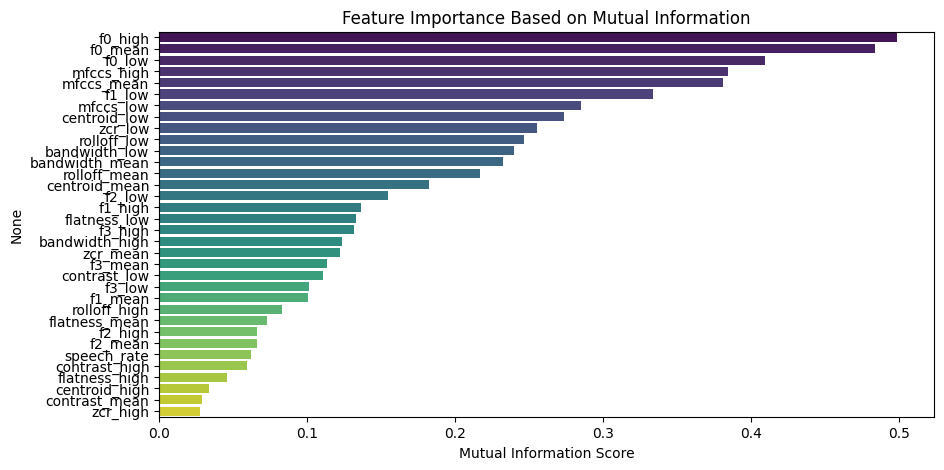

In [20]:
# Compute Mutual Information Scores
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Plot Mutual Information Scores
plt.figure(figsize=(10, 5))
sns.barplot(x=mi_scores.values, y=mi_scores.index, palette="viridis")
plt.xlabel("Mutual Information Score")
plt.title("Feature Importance Based on Mutual Information")
plt.show()

#### Random forest classifier

/tmp/ipykernel_746760/203487417.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette="magma")


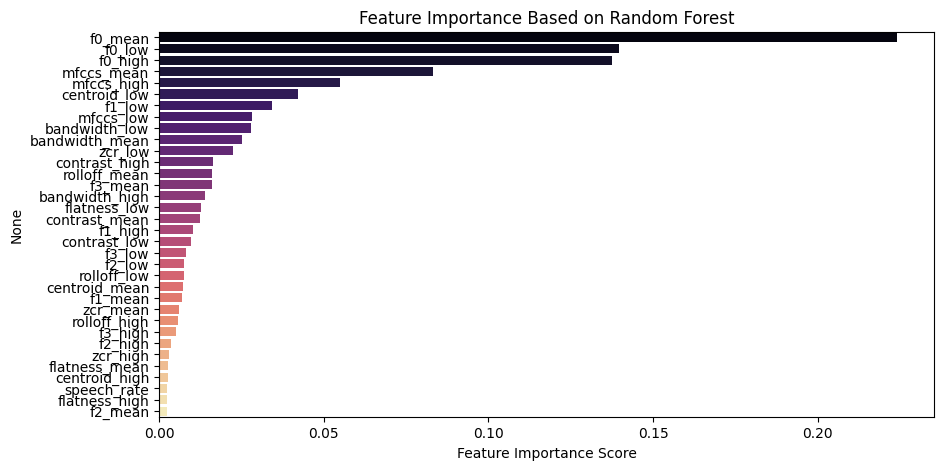

In [21]:
# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get Feature Importances
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 5))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette="magma")
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance Based on Random Forest")
plt.show()

**Thoughts:**

Based on the two plots above these features definitely seem to be the most important:

- F0 (fundamental frequency / pitch)
- MFCC (Mel-Frequency Cepstral Coefficients)
- F1 low (lowest percentile of first formant)

### Multicollinearity check

#### Correlation heatmap

There are a lot of features so to make the heatmap easier to read, I've only highlighted pairs with a correlation (magnitude) over 0.75.

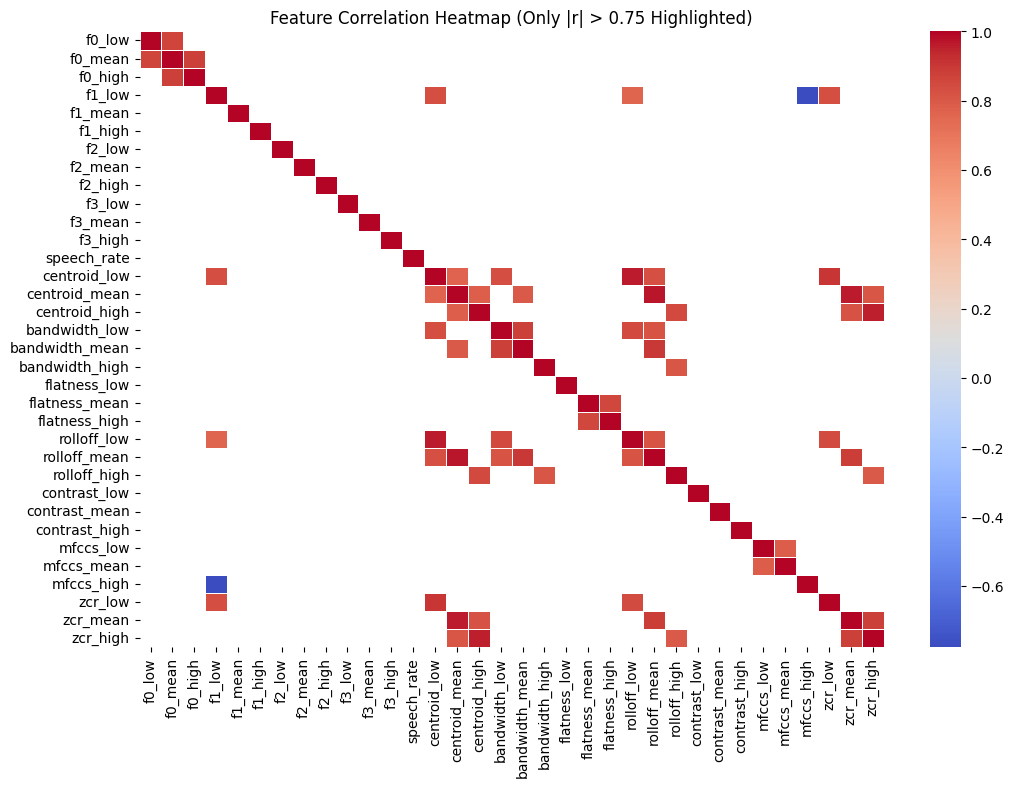

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Correlation Matrix
corr_matrix = X.corr()

# Mask correlations with absolute value ≤ 0.75
masked_corr_matrix = corr_matrix.copy()
masked_corr_matrix[np.abs(masked_corr_matrix) <= 0.75] = np.nan  # Set weak correlations to NaN

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(masked_corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5, mask=np.isnan(masked_corr_matrix))
plt.title("Feature Correlation Heatmap (Only |r| > 0.75 Highlighted)")
plt.show()

High-correlation pairs:

- ZCR & Centroid
- Rolloff & Centroid
- Rolloff & Bandwidth
- Rolloff & ZCR
- Flatness & F3_high

In short it seems a lot of the spectral features are highly correlated. This makes sense as they all display similar data i.e. frequency content of each voice.

## Feature Selection

Before experimenting with different feature subsets, let's see what kind of performance we get with all the features included.

Baseline Model Accuracy (All Features): 0.9898

🔍 Top 10 Most Important Features:
f0_mean           0.224179
f0_low            0.139685
f0_high           0.137611
mfccs_mean        0.083238
mfccs_high        0.055050
centroid_low      0.042085
f1_low            0.034173
mfccs_low         0.028098
bandwidth_low     0.027881
bandwidth_mean    0.025041
dtype: float64


/tmp/ipykernel_746760/1566800013.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values[:10], y=feature_importances.index[:10], palette="viridis")


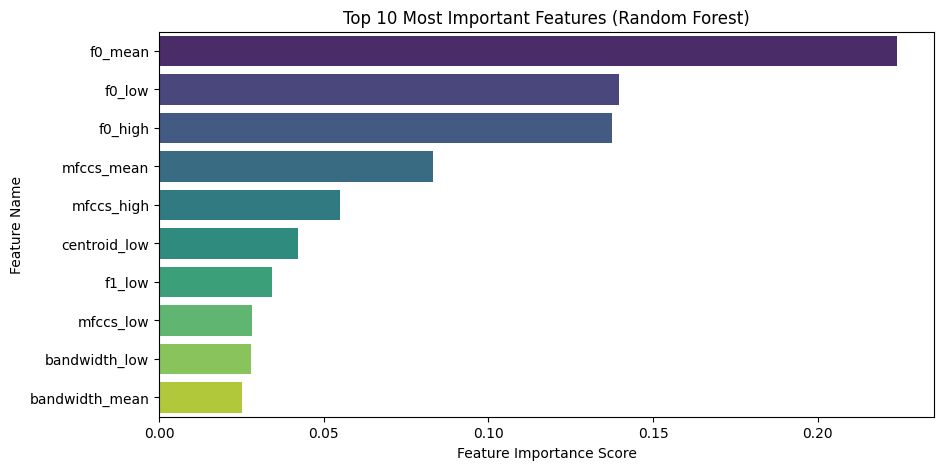

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define baseline model
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
baseline_model.fit(X, y)

# Evaluate model using cross-validation
baseline_score = cross_val_score(baseline_model, X, y, cv=5, scoring="accuracy").mean()
print(f"Baseline Model Accuracy (All Features): {baseline_score:.4f}")

# Get feature importance
feature_importances = pd.Series(baseline_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display Top 10 Important Features
print("\n🔍 Top 10 Most Important Features:")
print(feature_importances.head(10))

# Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances.values[:10], y=feature_importances.index[:10], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 10 Most Important Features (Random Forest)")
plt.show()

In [24]:
# Set importance threshold (features below this will be dropped)
IMPORTANCE_THRESHOLD = 0.01

# Identify important features
important_features = feature_importances[feature_importances > IMPORTANCE_THRESHOLD].index.tolist()

# Reduce dataset to only important features
X_selected = X[important_features]

print(f"✅ Retained {len(important_features)} important features out of {X.shape[1]} total features.")
print(f"❌ Dropped {X.shape[1] - len(important_features)} low-importance features.")

✅ Retained 18 important features out of 34 total features.
❌ Dropped 16 low-importance features.


In [25]:
# Split Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Train New Model
optimized_model = RandomForestClassifier(n_estimators=100, random_state=42)
optimized_model.fit(X_train, y_train)

# Evaluate New Model
optimized_score = cross_val_score(optimized_model, X_selected, y, cv=5, scoring="accuracy").mean()

print(f"\n🔍 Model Accuracy with Important Features Only: {optimized_score:.4f}")
print(f"🔄 Accuracy Change After Feature Reduction: {optimized_score - baseline_score:.4f}")


🔍 Model Accuracy with Important Features Only: 0.9879
🔄 Accuracy Change After Feature Reduction: -0.0019


As seen above, we can remove a lot of redundant features without any significant changes to model accuracy.

In [26]:
# Create a new DataFrame with only the selected important features
df_selected_features = df[["gender"] + important_features].copy()
df_selected_features.head()

,gender,f0_mean,f0_low,f0_high,mfccs_mean,mfccs_high,centroid_low,f1_low,mfccs_low,bandwidth_low,bandwidth_mean,zcr_low,contrast_high,rolloff_mean,f3_mean,bandwidth_high,flatness_low,contrast_mean,f1_high
0,male_masculine,130.818779,108.993591,146.258554,-10.568568,29.547817,489.358401,265.851550,-31.201262,700.483601,1310.654402,0.027783,52.054946,2479.276316,2478.982900,2012.538122,0.000039,26.215120,1263.481162
1,male_masculine,135.523808,116.957527,157.393003,-7.442534,37.559704,586.673348,285.907683,-36.300180,793.683841,1081.576322,0.039551,51.560272,1989.388021,2332.384782,1440.527678,0.000101,27.289864,1021.716462
2,male_masculine,96.514795,83.918983,111.966908,-7.741306,33.303170,542.347960,304.477289,-35.217650,700.868677,1313.437373,0.037598,51.387659,2591.906056,2383.874416,2105.891722,0.000038,25.994430,1233.993418
3,male_masculine,132.723163,108.302873,159.903372,-11.399430,36.645100,412.093687,257.935981,-31.623081,648.834714,1258.964986,0.025244,51.701784,2356.519170,2524.016499,2116.669648,0.000019,26.047613,1461.198076
4,male_masculine,167.550121,134.905055,194.577897,-15.239967,29.274729,470.516085,255.461981,-31.587460,655.293074,1389.433098,0.030957,50.341184,2613.715278,2571.740421,2102.135222,0.000013,26.064291,966.612765


In [27]:
df_selected_features.to_csv("df_selected_features.csv", index=False)

## Model Selection

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df = pd.read_csv("df_selected_features.csv")

X = df.drop(columns=["gender"])
y = df["gender"].astype("category").cat.codes  # Convert gender to numeric (e.g., Male=0, Female=1)

print(X.shape)
print(y.shape)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features (important for SVMs)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(5287, 18)
(5287,)


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

# Define Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", C=1.0, probability=True, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", max_iter=500, random_state=42)
}

# Train & Evaluate Models
results = {}
for name, model in models.items():
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean()
    results[name] = score
    print(f"✅ {name} Accuracy: {score:.4f}")

# Sort and Display Best Model
best_model_name = max(results, key=results.get)
print(f"\n🚀 Best Model: {best_model_name} with Accuracy: {results[best_model_name]:.4f}")

✅ Random Forest Accuracy: 0.9875
✅ SVM Accuracy: 0.9877
✅ Neural Network Accuracy: 0.9910

🚀 Best Model: Neural Network with Accuracy: 0.9910
